## QOSF Screening Task 2

Implement a circuit that returns |01> and |10> with equal probability.
Requirements :
The circuit should consist only of CNOTs, RXs and RYs.
Start from all parameters in parametric gates being equal to 0 or randomly chosen.
You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like).
Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise.

Compare the results for different numbers of measurements: 1, 10, 100, 1000.

Bonus question:
How to make sure you produce state |01> + |10> and not |01> - |10> ?

### Imported Libraries 
Using pennylane for training the parameters and qiskit for circuit simulation

In [1078]:
#Import Libraries
import qiskit as qk
import random
from math import pi
import matplotlib.pyplot as plt
from qiskit import(QuantumCircuit,execute,Aer,IBMQ)
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit.quantum_info import Statevector
from qiskit.providers.aer.noise import NoiseModel

**Create QML Model and Fetch Gradient Descent Optimizer**

In [1079]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer

**Build noise model from backend properties**

In [1080]:
IBMQ.save_account('0fbdb382eb11ab0fe752ceccce6e05056adafba8b5b0036998ee49a6ff117d799049d633f04529d2c8692710bfd02974e2fa9c3981b9357ccb166452de5b0211')
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

configrc.store_credentials:WARNING:2020-09-26 22:27:40,484: Credentials already present. Set overwrite=True to overwrite.
c:\users\prishitaray\appdata\programs\python\python37\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-09-26 22:27:42,961: Credentials are already in use. The existing account in the session will be replaced.


**Get coupling map from backend**

In [1081]:
coupling_map = backend.configuration().coupling_map

**Get basis gates from noise model**

In [1082]:
basis_gates = noise_model.basis_gates

**Create qubits and classical bits**

In [1083]:
q=qk.QuantumRegister(2)
c=qk.ClassicalRegister(2)

### Approach and Circuit Design
In this task, the expected outcome is to have a circuit that can generate the qubit states |01> and |10> with equal probabilities, using RX, RY and CNOT gates. 

For this purpose, starting with the qubits state |0>|0, the RY gate was applied on the first qubit with a rotation angle $\theta$ so as to produce the intermediate state after the operation:  ($cos\frac{\theta}{2}$|0> + $sin\frac{\theta}{2}$|1>)|0>. The RY rotation operation can be explained as follows:

Starting with the first state $\lvert0\rangle = \begin{bmatrix} 0\\1 \end{bmatrix}$  
  
The RY gate is applied to this state with a rotation angle $\theta$
  
$$
\begin{aligned}
    RY(\theta) & = 
    \begin{bmatrix} 
        cos(\frac{\theta}{2}) & -sin(\frac{\theta}{2}) \\ 
        sin(\frac{\theta}{2}) & cos(\frac{\theta}{2})
    \end{bmatrix}
\end{aligned}
$$  

Then the intermediate state produced by applying RY($\theta$) on the first state is:

$$
\begin{bmatrix} 
    0 \\
    1 
\end{bmatrix}
\xrightarrow{RY(\theta)}
\begin{bmatrix} 
    cos(\frac{\theta}{2}) \\
    sin(\frac{\theta}{2})
\end{bmatrix}
$$

Thus the states now become ($cos\frac{\theta}{2}$|0> + $sin\frac{\theta}{2}$|1>)|0>

The first qubit returns states |0> and |1> with equal probabilty.

A CNOT gate is then implemented from qubit 0 to qubit 1 to try and eliminate unwanted states, to only allow the combined states |00> and |11> with an equal probability. 

$$
\begin{aligned}
(cos\frac{\theta}{2}|0> + sin\frac{\theta}{2}|1>)|0> \xrightarrow{CX} cos\frac{\theta}{2}|00> + sin\frac{\theta}{2}|11>
\end(aligned)
%

The CNOT gate will reverse the state of the second qubit only when the first qubit state is |1>. In this case, CX when applied on ($cos\frac{\theta}{2}$|0>)|0> will return $cos\frac{\theta}{2}$|00> and CX when applied to ($sin\frac{\theta}{2}$|1>)|0> will return  $sin\frac{\theta}{2}$|11> as the state of the first qubit is |1>, hence the state of the second qubit, that is |0> gets reversed to |1>

Finally, when an RX rotation operation is performed with an angle of $\pi$, the half angle $\frac{\pi}{2}$ will rotate the current states by 90 degrees anticlockwise. Thus |00> will become |01> and |11> will become |10> which can be visualized on the quantum sphere. 


<center>$cos\frac{\theta}{2}$|00> + $sin\frac{\theta}{2}$|11> $\xrightarrow{RX(\pi)}$ $cos\frac{\theta}{2}$|01> + $sin\frac{\theta}{2}$|10> </center>

Thus, it can be observed that the states |01> and |10> can be returned with an equal probability.

The only parameter that needs to be optimized is the $\theta$ RY rotation angle, such that these two states can be equally observed in a given time frame. 

### Optimizing the Parameters

In [1056]:
dev = qml.device("default.qubit",wires=2)

In [1057]:
target_state = np.tensor([0, 0.5, 0.5, 0])

In [1058]:
#Training Vigo Noise Model
#params=random.vonmisesvariate(mu=0, kappa=4)

steps = 1500
params1 = np.random.rand(1)
params = np.random.rand(1)
opt = GradientDescentOptimizer(0.1)
density = np.outer(target_state, target_state)

@qml.qnode(dev)
def circuit(var,noise=0.0):
    density = np.outer(target_state, target_state)
    qml.RY(var[0], wires=0)
    qml.CNOT(wires=[0,1])
    qml.RX(pi, wires=1)
    return qml.expval(qml.Hermitian(density, wires=[0,1]))

def cost(var):
    return 0.5-circuit(var)

def noise_cost(var):
    return 0.5-circuit(var,noise=0.3)

costs=[]

for i in range(steps):
    params = opt.step(cost, params)

    if (i + 1) % 100 == 0:
        print("Iteration Number {:5d} Cost: {: .20f}".format(i + 1, cost(params)))
    costs.append(cost(params))

print("Optimized parameters (theta for Ry) without noise: {}".format(params))



Iteration Number   100 Cost:  0.00105966998661238820
Iteration Number   200 Cost:  0.00000671479734526415
Iteration Number   300 Cost:  0.00000004245824081206
Iteration Number   400 Cost:  0.00000000026846358470
Iteration Number   500 Cost:  0.00000000000169753100
Iteration Number   600 Cost:  0.00000000000001088019
Iteration Number   700 Cost:  0.00000000000000000000
Iteration Number   800 Cost:  0.00000000000000000000
Iteration Number   900 Cost:  0.00000000000000000000
Iteration Number  1000 Cost:  0.00000000000000011102
Iteration Number  1100 Cost:  0.00000000000000011102
Iteration Number  1200 Cost:  0.00000000000000000000
Iteration Number  1300 Cost:  0.00000000000000000000
Iteration Number  1400 Cost:  0.00000000000000011102
Iteration Number  1500 Cost:  0.00000000000000011102
Optimized parameters (theta for Ry) without noise: [1.57079633]


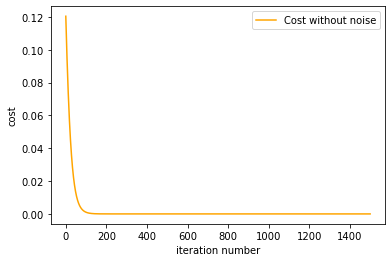

In [1059]:
colours = ["orange","purple"]
plt.plot(range(steps), costs, colours[0], label="Cost without noise", linewidth=1.5)
plt.xlabel('iteration number')
plt.ylabel('cost')
plt.legend()
plt.show()

In [1060]:
#==================================================
# Rotation Operation Ry along y-axis on first qubit 
#==================================================
circuit=qk.QuantumCircuit(q)
circuit.ry(params[0],q[0])

In [1061]:
#============================================================================================
#CNOT Gate on the first to the second qubit (Negates second state only if first state is 1)
#============================================================================================
circuit.cx(0,1)

In [1062]:
#===================================================
#Rotation Operation Rx along x-axis on second qubit 
#===================================================
circuit.rx(pi,q[1])

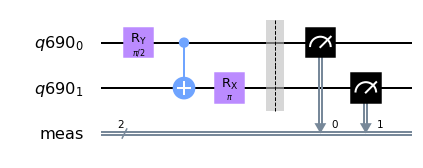

In [1063]:
#===============
#Display circuit
#===============
circuit.measure_all()
circuit.draw('mpl')

In [1064]:
simulator = Aer.get_backend('qasm_simulator')
sv_simulator = Aer.get_backend('statevector_simulator')

In [1065]:
#Checking for 1 measurements
# Execute the circuit on the qasm simulator
job = execute(circuit, simulator, shots=1,noise_model=noise_model)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 01 and 10 are:",counts)


Total count for 01 and 10 are: {'10': 1}


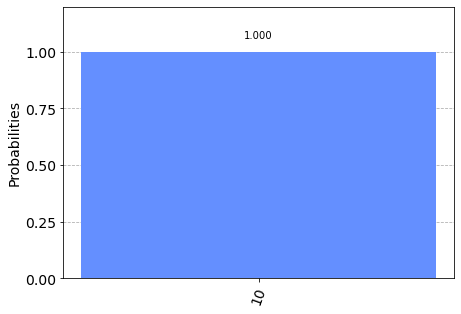

In [1066]:
#Histogram of probabilities for 01 and 10 in one measurement
plot_histogram(counts)


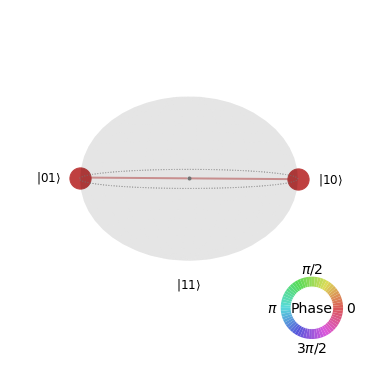

In [1067]:
plot_state_qsphere(
    Statevector.from_label('00').evolve(circuit.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
)

In [1068]:
#Checking for 10 measurements
# Execute the circuit on the qasm simulator
job = execute(circuit, simulator, shots=10,noise_model=noise_model)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 01 and 10 are:",counts)


Total count for 01 and 10 are: {'01': 3, '10': 7}


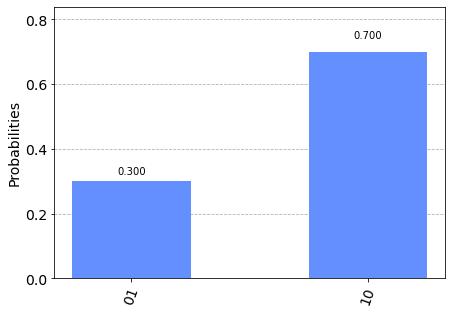

In [1069]:
#Histogram of probabilities for 01 and 10 in ten measurements
plot_histogram(counts)

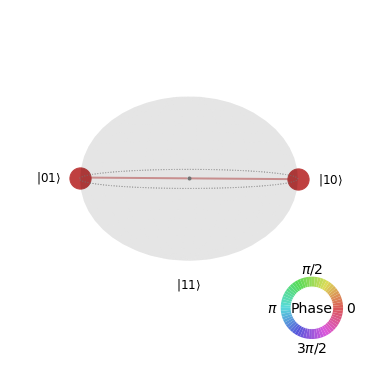

In [1070]:
plot_state_qsphere(
    Statevector.from_label('00').evolve(circuit.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
)

In [1071]:
#Checking for 100 measurements
# Execute the circuit on the qasm simulator
job = execute(circuit, simulator, shots=100,noise_model=noise_model)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 01 and 10 are:",counts)


Total count for 01 and 10 are: {'01': 50, '10': 48, '11': 2}


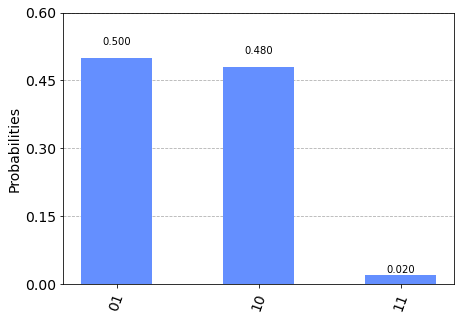

In [1072]:
#Histogram of probabilities for 01 and 10 in hundred measurements
plot_histogram(counts)

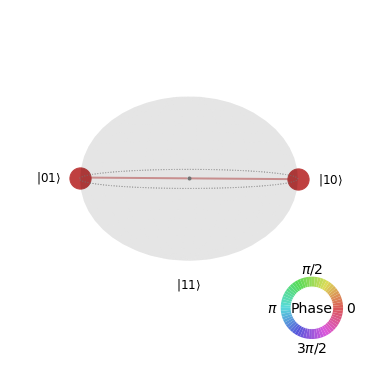

In [1073]:
plot_state_qsphere(
    Statevector.from_label('00').evolve(circuit.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
)

In [1074]:
#Checking for 1000 measurements
# Execute the circuit on the qasm simulator
job = execute(circuit, simulator, shots=1000, noise_model=noise_model)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 01 and 10 are:",counts)


Total count for 01 and 10 are: {'00': 19, '01': 462, '10': 508, '11': 11}


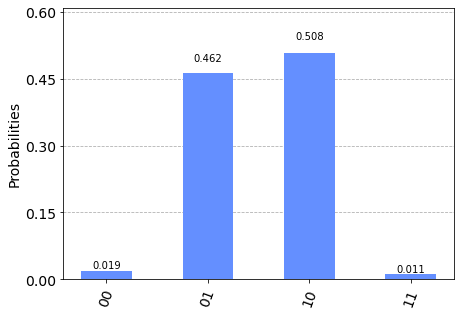

In [1075]:
#Histogram of probabilities for 01 and 10 in thousand measurements
plot_histogram(counts)

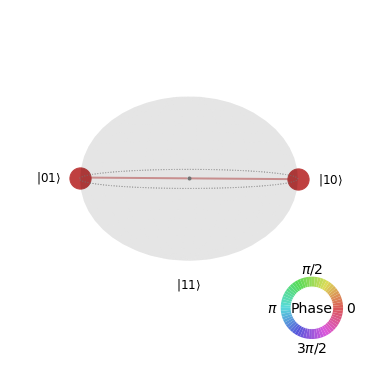

In [1076]:
plot_state_qsphere(
    Statevector.from_label('00').evolve(circuit.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
)

In [1077]:
#Bonus Question 